In [ ]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import RFutils
import dask
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import cf_xarray as cfxr
import scipy.signal as signal
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve_triangular

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from sklearn.linear_model import LinearRegression

import copy
import os

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
model_set = RFutils.model_set
A = RFutils.A
ds_out = RFutils.ds_out

plot = True
savgol = True
save = False

train = 'historical'
print(f'Loading {train} ERF data.')

if 'ssp' in train: SSP = True
else: SSP = False

if 'hist' in train: hist = True
else: hist = False

# Import required datasets
ERF = {}
ERF_smooth = {}
ERF[train] = RFutils.load_ERF_set(model_set, train, print_var = False)

# Regrid, smooth, and check condition number of data
for m in ERF[train]:
    ERF[train][m] = RFutils.regrid_cmip(ERF[train][m],ds_out)
    ERF[train][m] = ERF[train][m].weighted(A).mean(dim = ['lat','lon'])
    ERF[train][m] = ERF[train][m].assign_coords({'year':ERF[train][m].year - ERF[train][m].year[0]})

    if SSP == True and max(ERF[train][m].year.values) > 84:
        ERF[train][m] = ERF[train][m].sel(year = slice(0,84))

    elif SSP == False and hist == False and max(ERF[train][m].year.values) > 149:
        ERF[train][m] = ERF[train][m].sel(year = slice(0,149))
        
    elif hist == True and max(ERF[train][m].year.values) > 164:
        ERF[train][m] = ERF[train][m].sel(year = slice(0,164))

ERF_smooth[train] = copy.deepcopy(ERF[train])
for m in ERF[train]:
    if m in ['MIROC6','ACCESS-ESM1-5','CAMS-CSM1-0']:
        ERF_smooth[train][m].ERF.values = savgol_filter(ERF[train][m]['ERF'].values + ERF[train][m]['ERF'].values[2],100,3,mode='nearest')
    else:
        ERF_smooth[train][m].ERF.values = savgol_filter(ERF[train][m]['ERF'].values,100,3,mode='nearest')

RFutils.check_data(ERF_smooth,train)

Loading historical ERF data.
	 Loading INM-CM4-8 data...
	 Loading NorESM2-LM data...
	 Loading CAMS-CSM1-0 data...
	 Loading MIROC6 data...
	 Loading INM-CM5-0 data...
	 Loading ACCESS-CM2 data...
	 Loading MRI-ESM2-0 data...
	 Loading CanESM5 data...
	 Loading ACCESS-ESM1-5 data...


/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/cf_xarray/accessor.py:1767: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/cf_xarray/accessor.py:1767: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/cf_xarray/accessor.py:1767: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/home/cwomack/.conda/envs/gchp/lib/python3.9/site-packages/cf_xarray/accessor.py:1767: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/home/cwomack/

Model: INM-CM4-8, Condition Number: 1239.2645796735967
Model: NorESM2-LM, Condition Number: 543.5032116867498
Model: CAMS-CSM1-0, Condition Number: 4106.809888027513
Model: MIROC6, Condition Number: 267.2910332179573
Model: INM-CM5-0, Condition Number: 2290.575814970765
Model: ACCESS-CM2, Condition Number: 711.7444793579361
Model: MRI-ESM2-0, Condition Number: 2097.2694695460946
Model: CanESM5, Condition Number: 526.5232076363669
Model: ACCESS-ESM1-5, Condition Number: 514.3809346674765


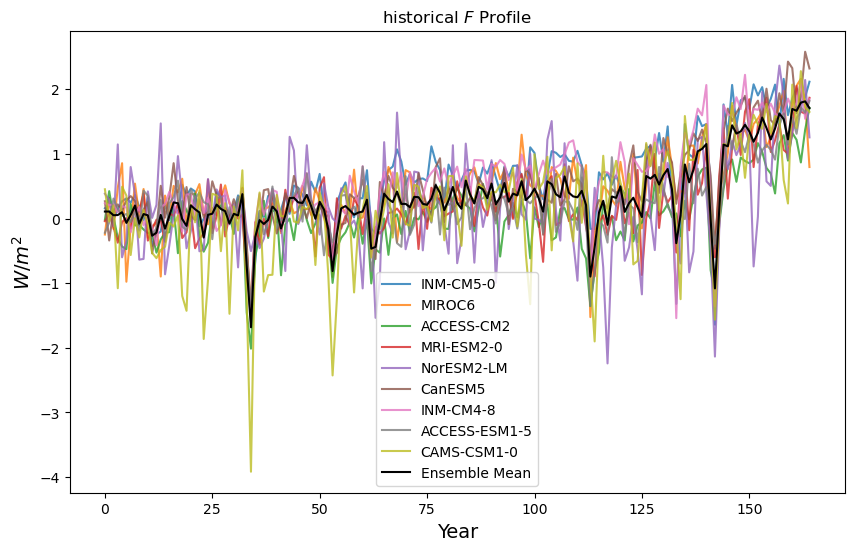

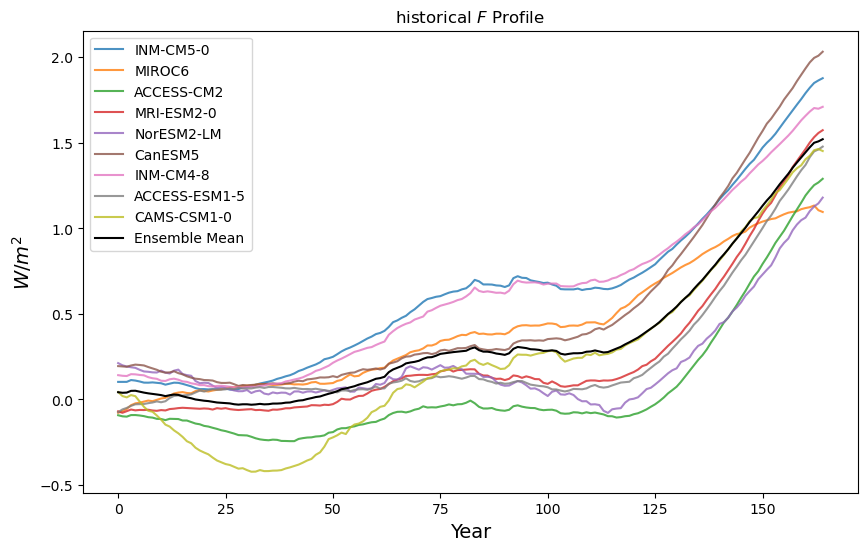

In [10]:
train = 'historical'

ERF_path = f'../Outputs/RF_Outputs/ERF/ERF_{train}_all_ds.nc4'
ERF_ds = xr.open_dataset(ERF_path)

ERF_smooth_path = f'../Outputs/RF_Outputs/ERF/ERF_{train}_smooth_all_ds.nc4'
ERF_smooth_ds = xr.open_dataset(ERF_smooth_path)

#ERFplot = copy.deepcopy(ERF)
#ERFplot_smooth = copy.deepcopy(ERF_smooth)
#ERF_ds = RFutils.concat_multirun(ERFplot[train], 'model')
#ERF_smooth_ds = RFutils.concat_multirun(ERFplot_smooth[train], 'model')
model_color = RFutils.model_color
type_color = RFutils.type_color
RFutils.plot_ERF_profile(ERF_ds, train, model_color, save_fig = False)
RFutils.plot_ERF_profile(ERF_smooth_ds, train, model_color, save_fig = False)

In [4]:
ERF[train] = RFutils.concat_multirun(ERF[train],'model')
ERF_smooth[train] = RFutils.concat_multirun(ERF_smooth[train],'model')

ERF[train].to_netcdf(f'../Outputs/RF_Outputs/ERF_{train}_all_ds.nc4')
ERF_smooth[train].to_netcdf(f'../Outputs/RF_Outputs/ERF_{train}_smooth_all_ds.nc4')